### Notebook to plot static stability characteristics (and CFADs) from BOWTIE sounding data.

James Ruppert  
jruppert@ou.edu  
8/19/24

### Main settings

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc, colors, ticker
import matplotlib.dates as mdates
from thermo_functions import *
import subprocess, cmocean
import xarray as xr
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from time_series_diag import *
from bowtie_read_data import *

In [2]:
# Soundings
snd_asc, snd_files, times_asc = read_bowtie_soundings(search_string = 'ascen')
# soundings, snd_files, times_snd = read_bowtie_soundings(search_string = 'descen')
hght = snd_asc['hght']

### Compute diagnostics

In [3]:
# Vertical mass-weighted integral
#   inputs:
#       tmpk:   temperature [K]
#       mr:     water vapor mixing ratio [kg/kg]
#       p:      pressure [Pa]
#       hght:   height [m]
#   options:
#       minpres: set this to minimum pressure to integrate over [Pa]
def vert_integral(invar, tmpk, mr, p, hght, minpres=0):
    rho = density_moist(tmpk, mr, p) # kg/m3
    dz = hght[1]-hght[0] # m
    var_int = np.nansum(invar*rho, axis=1, where=(p > minpres))*dz
    var_int[ np.where(var_int == 0) ] = np.nan
    return var_int

In [4]:
# Constants
cp=1004.  # J/K/kg
cpl=4186. # J/k/kg
cpv=1885. # J/K/kg
lv0=2.5e6 # J/kg
g = 9.81 # m/s2
# Latent heat of vaporization
lv = lv0 - (cpl-cpv)*(snd_asc['tmpk']-273.15)

minpres=50e2 # Upper pressure bound for vertical integrals [Pa]

# MSE
dse = cp*snd_asc['tmpk'] + g*hght[np.newaxis,:]
lvq= lv*snd_asc['mr']
mse = dse + lvq

# Static stability
theta = theta_dry(snd_asc['tmpk'], snd_asc['p'])
def smooth_theta(invar, nz_smooth=10):
    invar_pd = pd.DataFrame(invar)
    invar_pd = invar_pd.rolling(axis=1,window=nz_smooth, center=True, closed='both', min_periods=3).mean()
    return np.squeeze(np.array(invar_pd))
for ido in range(3):
    theta = smooth_theta(theta, nz_smooth=10)
dthdz = np.gradient(theta, hght, axis=1) # K/m
# for ido in range(10):
dthdz = smooth_theta(dthdz, nz_smooth=20)

tmpk_ddz = np.copy(snd_asc['tmpk'])
for ido in range(3):
    tmpk_ddz = smooth_theta(tmpk_ddz, nz_smooth=10)
dtdz = np.gradient(tmpk_ddz, hght, axis=1) # K/m
dtdz = smooth_theta(dtdz, nz_smooth=20)

# CWV/PW
# 1/g int(q)dp = s2/m * kg/m/s2 --> kg/m2 --> x1/rho_l --> 10^-3 kg/m2*m3/kg --> 10^-3m = mm
# int<q*rho>dz = kg/m3*m = kg/m2 = mm
cwv = vert_integral(snd_asc['mr'], snd_asc['tmpk'], snd_asc['mr'], snd_asc['p'],
                    hght, minpres=0) # mm or kg/m2

/var/folders/9x/209ltwrn2b359nrrh4638hv40000gp/T/ipykernel_15278/1126967735.py:21: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  invar_pd = invar_pd.rolling(axis=1,window=nz_smooth, center=True, closed='both', min_periods=3).mean()
/var/folders/9x/209ltwrn2b359nrrh4638hv40000gp/T/ipykernel_15278/1126967735.py:21: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  invar_pd = invar_pd.rolling(axis=1,window=nz_smooth, center=True, closed='both', min_periods=3).mean()
/var/folders/9x/209ltwrn2b359nrrh4638hv40000gp/T/ipykernel_15278/1126967735.py:21: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  invar_pd = invar_pd.rolling(axis=1,window=nz_smooth, center=True, closed='both', min_periods=3).mean()
/var/folders/

---
### Plotting routines

#### Plot functions

In [11]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 12}

rc('font', **font)

# sns.set_theme(style="darkgrid", rc={'xtick.bottom': True, 'ytick.left': True,})

In [12]:
# def do_smooth(invar, nt_smooth=3, nz_smooth=10):
def do_smooth(invar, nt_smooth=8, nz_smooth=10):
    # Use Pandas to compute rolling average
    invar_pd = pd.DataFrame(invar)
    var_sm1 = invar_pd.rolling(window=nt_smooth, center=True, closed='both', min_periods=3).mean()
    # var_trns = var_sm1.transpose()
    # var_sm = var_trns.rolling(window=nz_smooth, center=True, closed='both', min_periods=3).mean()
    # var_sm = var_sm1.transpose()
    # return np.squeeze(np.array(var_sm.transpose()))
    return np.squeeze(np.array(var_sm1))
# def do_smooth(invar, nt_smooth=3, nz_smooth=10):
def do_smooth_2d(invar, nt_smooth=8):
    # Use Pandas to compute rolling average
    invar_pd = pd.DataFrame(invar)
    var_sm = invar_pd.rolling(window=nt_smooth, center=True, closed='both', min_periods=3).mean()
    return np.squeeze(np.array(var_sm))

##### Time-height series stuff

In [13]:
def plot_time_height(figdata, smooth=False, top=18, do_log=False):

    fig_x = 9
    fig_y = 3.5
    fig, ax = plt.subplots(figsize=(fig_x,fig_y), layout="constrained",) # row, column

    ax.set_title(figdata['fig_title'])

    ax.set_ylabel('Height [km]')
    ax.set_ylim(0,top)
    # ax.set_xlim(figdata['xlim'])
    ax.set_xlabel('Date [UTC]')

    ax.grid(True, axis='x', color='0.55', linewidth=0.5, zorder=4)
    ax.grid(True, axis='y', color='0.55', linewidth=0.5, zorder=4)#, which='both')

    # Plot variable
    xdim=figdata['time']
    pltvar = figdata['pltvar']
    if smooth:
        pltvar = do_smooth(pltvar)

    # norm=colors.Normalize(np.min(figdata['clevels']), np.max(figdata['clevels']))
    # im = ax.pcolormesh(np.repeat(xdim[:,np.newaxis],len(hght),axis=1), np.repeat(hght[np.newaxis,:]*1e-3,len(xdim),axis=0), pltvar, cmap=figdata['cmap'], shading='gouraud', norm=norm)#figdata['norm'])
    im = ax.contourf(xdim, hght*1e-3, pltvar.transpose(), figdata['clevels'],
                    extend=figdata['extend'], cmap=figdata['cmap'], zorder=0)#, norm=norm)
    fig.colorbar(im, ax=ax, label=figdata['units'], ticks=ticker.AutoLocator())#, shrink=0.6)

    # Line contours
    im = ax.contour(xdim, hght*1e-3, pltvar.transpose(), figdata['clevels_line'],
                    colors=figdata['clevels_line_color'],linewidths=0.6, zorder=1)

    # 0ºC level
    hght0c = snd_asc['hght_0c']*1e-3
    if smooth:
        invar_pd = pd.DataFrame(hght0c)
        nt_smooth=3
        invar_sm = invar_pd.rolling(window=nt_smooth, center=True, closed='both', min_periods=3).mean()
        hght0c=np.squeeze(np.array(invar_sm))
    # ax.plot(figdata['time'], hght0c, color='#d62728', zorder=3, linewidth=2)

    # Time labels
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))

    plt.show()
    plt.close()
    return

In [14]:
def plot_time_height_subpanel(figdata, smooth=False, cwv=None, do_log=False, top=18):

    fig_x = 9
    # fig_y = 3.5
    # fig, ax = plt.subplots(figsize=(fig_x,fig_y), layout="constrained",) # row, column
    fig_y = 6
    fig, axs = plt.subplots(2, 1, figsize=(fig_x,fig_y), height_ratios=[.65,.35], layout='constrained',squeeze=True)

    axs[0].set_title(figdata['fig_title'])

    axs[0].set_ylabel('Height [km]')
    axs[0].set_ylim(0,top)
    axs[0].set_xlim(figdata['xlim'])
    # axs[0].set_xlabel('Date')

    axs[0].grid(True, axis='x', color='0.55', linewidth=0.5, zorder=4)
    axs[0].grid(True, axis='y', color='0.55', linewidth=0.5, zorder=4)#, which='both')

    # Plot variable
    xdim=figdata['time']
    pltvar = figdata['pltvar']
    if smooth:
        pltvar = do_smooth(pltvar)

    # norm=colors.Normalize(np.min(figdata['clevels']), np.max(figdata['clevels']))
    # im = ax.pcolormesh(np.repeat(xdim[:,np.newaxis],len(hght),axis=1), np.repeat(hght[np.newaxis,:]*1e-3,len(xdim),axis=0), pltvar, cmap=figdata['cmap'], shading='gouraud', norm=norm)#figdata['norm'])
    im = axs[0].contourf(xdim, hght*1e-3, pltvar.transpose(), figdata['clevels'],
                    extend=figdata['extend'], cmap=figdata['cmap'], zorder=0)#, norm=figdata['norm'])
    fig.colorbar(im, ax=axs[0], label=figdata['units'], ticks=ticker.AutoLocator())#, shrink=0.6)

    # Line contours
    im = axs[0].contour(xdim, hght*1e-3, pltvar.transpose(), figdata['clevels_line'],
                    colors=figdata['clevels_line_color'],linewidths=0.6, zorder=1)

    # 0ºC level
    hght0c = snd_asc['hght_0c']*1e-3
    if smooth:
        invar_pd = pd.DataFrame(hght0c)
        nt_smooth=3
        invar_sm = invar_pd.rolling(window=nt_smooth, center=True, closed='both', min_periods=3).mean()
        hght0c=np.squeeze(np.array(invar_sm))
    # ax.plot(figdata['time'], hght0c, color='#d62728', zorder=3, linewidth=2)

    # Time labels
    axs[0].xaxis.set_major_locator(mdates.AutoDateLocator())
    axs[0].xaxis.set_major_formatter(mdates.ConciseDateFormatter(axs[0].xaxis.get_major_locator()))
    # axs[0].get_xaxis().set_ticks([' ', ' ',' ',' ',' ',' ',' ',' '])

    # Hide labels
    axs[0].xaxis.set_ticklabels([])

    ##################################################

    # CWV SUBPANEL
    axs[1].set_ylabel('IWV [mm]')
    axs[1].set_ylim(48,66)

    # Time labels
    axs[1].set_xlim(figdata['xlim'])
    axs[1].xaxis.set_major_locator(mdates.AutoDateLocator())
    axs[1].xaxis.set_major_formatter(mdates.ConciseDateFormatter(axs[0].xaxis.get_major_locator()))

    cwv_plt = np.copy(cwv)
    if smooth:
        cwv_plt = do_smooth_2d(cwv_plt)
    axs[1].plot(xdim, cwv_plt, '-k')
    axs[1].set_xlabel('Date')

    # axs[1].axhline(y=48, color='red', linewidth=0.8, zorder=0)

    plt.show()
    plt.close()
    return

##### CFAD stuff

In [15]:
def compute_cfad(invar, bins):
    nz = invar.shape[1]
    nbin = len(bins)
    var_freq=np.zeros((nbin-1,nz))
    for iz in range(nz):
        count, placeholder = np.histogram(invar[:,iz], bins=bins)
        # var_freq[:,iz] = 100 * count / np.sum(count)
        var_freq[:,iz] = count
    return var_freq

In [16]:
def plot_cfad(figdata):

    fig_x = 5
    fig_y = 4.5
    fig, ax = plt.subplots(figsize=(fig_x,fig_y), layout="constrained",) # row, column

    ax.set_title(figdata['fig_title'])
    # fig.suptitle(figdata['fig_title'])

    ax.set_ylabel('Height [km]')
    ymax=10#20
    ax.set_xlim(figdata['bins'].min(),figdata['bins'].max())
    ax.set_ylim(0,ymax)
    ax.set_xlabel(figdata['xtitle'])

    ax.grid(True, axis='x', color='0.55', linewidth=0.5)
    ax.grid(True, axis='y', color='0.55', linewidth=0.5)#, which='both')

    # Plot CFAD
    pltvar=figdata['pltvar'][:,:-1]
    norm=colors.Normalize(vmin=0, vmax=15)
    # norm=colors.LogNorm()#vmin=1, vmax=10)
    cmap=cmocean.cm.rain
    im = ax.pcolormesh(figdata['bins'], hght*1e-3, pltvar.transpose(), cmap=cmap, norm=norm)
    fig.colorbar(im, ax=ax, label='Frequency [%]')#, shrink=0.6)

    # Plot mean
    ax.plot(figdata['meanvar'], hght*1e-3, '-', color='#d62728', linewidth=1.9, label=r'Mean d$\theta$/dz')

    # Plot 0ºC
    ax.axhline(y=figdata['zeroc']*1e-3, color='black', linestyle='--', linewidth=1, label='0$^\circ$C')
    ax.axhline(y=figdata['zeroc']*0, color='green', linewidth=2, label='Mean RH')

    plt.legend()

    # Plot mean RH
    if 'mean_rh' in figdata.keys():
        twiny = ax.twiny()
        twiny.plot(figdata['mean_rh'], hght*1e-3, '-', color='green', linewidth=1.9)
        twiny.set_xlim((25,100))

    plt.show()
    plt.close()
    return

In [ ]:
def plot_cfad_multi(figdata, fig, ax, do_colorbar=False, ianom=False):

    ax.set_title(figdata['fig_title'])

    ax.set_xlim(figdata['bins'].min(),figdata['bins'].max())
    ax.set_ylim(0,16)
    ax.grid(True, axis='x', color='0.55', linewidth=0.5)
    ax.grid(True, axis='y', color='0.55', linewidth=0.5)#, which='both')

    # Plot CFAD
    pltvar=figdata['pltvar'][:,:-1]
    if ianom:
        norm=colors.Normalize(vmin=-5, vmax=5)
        cmap='RdBu_r'
    else:
        norm=colors.Normalize(vmin=0, vmax=15)
        cmap=cmocean.cm.rain
    # norm=colors.LogNorm()#vmin=1, vmax=10)
    im = ax.pcolormesh(figdata['bins'], hght*1e-3, pltvar.transpose(), cmap=cmap, norm=norm)
    if do_colorbar:
        fig.colorbar(im, ax=ax, label='Frequency [%]')#, shrink=0.6)

    # Plot mean
    ax.plot(figdata['meanvar'], hght*1e-3, '-', color='#d62728', linewidth=1.9, label=r'Mean d$\theta$/dz')

    # Plot 0ºC
    ax.axhline(y=figdata['zeroc']*1e-3, color='black', linestyle='--', linewidth=1, label=r'0$^\circ$C')
    ax.axhline(y=figdata['zeroc']*0, color='green', linewidth=2, label='Mean RH')

    # Plot mean RH
    if 'mean_rh' in figdata.keys():
        twiny = ax.twiny()
        twiny.plot(figdata['mean_rh'], hght*1e-3, '-', color='green', linewidth=1.9)
        twiny.set_xlim((25,100))
        if ianom:
            twiny.set_xlim((-30,30))

    return

#### Time-height series

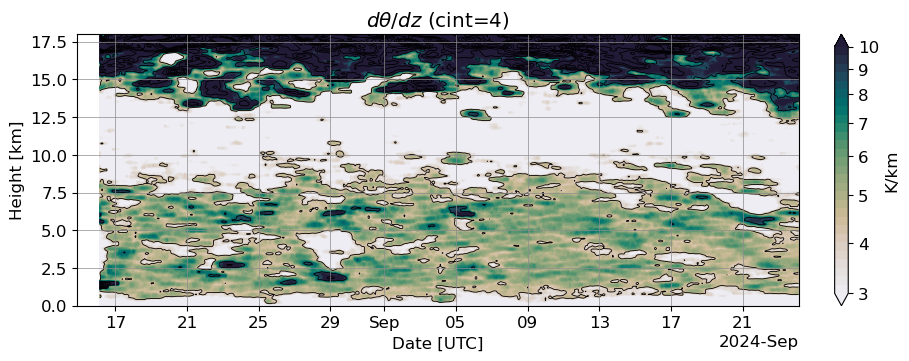

In [17]:
xlim=(times_asc[0],times_asc[-1])
# xlim=(times_asc[-48*2],times_asc[-1])
# xlim=[np.datetime64('2024-08-23T00:00'), np.datetime64('2024-08-27T00:00')]

# d(th)/dz

cint_lines = 4
contours = np.arange(cint_lines,cint_lines*10,cint_lines)

# dthdz_asc = np.copy(dthdz)
# dthdz_asc -= (np.nanmean(dthdz_asc, axis=0))[np.newaxis,:]

figdata = {
    'pltvar': dthdz*1e3,
    'time': times_asc,
    'fig_title': r'$d\theta/dz$ (cint='+str(cint_lines)+')',
    'units': 'K/km',
    'cmap': cmocean.cm.rain,
    'clevels': np.logspace(0.5,1.,num=30),
    'clevels_line': contours,
    'clevels_line_color': 'black',
    'extend': 'both',
    'xlim': xlim,
           }

plot_time_height(figdata, smooth=True, do_log=True)

#### CFADS

##### Mean CFAD

/var/folders/9x/209ltwrn2b359nrrh4638hv40000gp/T/ipykernel_15278/579862849.py:11: RuntimeWarning: Mean of empty slice
  var_mean = np.nanmean(cfad_invar, axis=0)
/var/folders/9x/209ltwrn2b359nrrh4638hv40000gp/T/ipykernel_15278/579862849.py:15: RuntimeWarning: Mean of empty slice
  mean_rh = np.nanmean(rh_asc, axis=0)


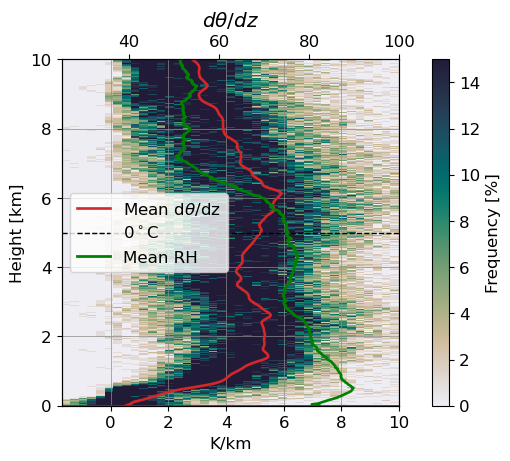

In [18]:
# Bin settings
nbin=40
fmin=-2
fmax=10#15
step=(fmax-fmin)/nbin
bins=np.arange(fmin,fmax,step)+step

cfad_invar = dthdz*1e3 # K/km

var_cfad = compute_cfad(cfad_invar, bins)
var_mean = np.nanmean(cfad_invar, axis=0)

rh_asc = calc_relh(snd_asc['mr'], snd_asc['p'], snd_asc['tmpk'], ice=True)

mean_rh = np.nanmean(rh_asc, axis=0)

figdata = {
    'pltvar': var_cfad,
    'meanvar': var_mean,
    'bins': bins,
    'zeroc': np.nanmean(snd_asc['hght_0c']),
    'mean_rh':  mean_rh,
    'fig_title': r'$d\theta/dz$',
    'xtitle': 'K/km',
    'extend': 'both',
           }

plot_cfad(figdata)

##### Binned by CWV

In [19]:
# # Apply STD thresholds to smoothed CWV to isolate dry/wet periods

# cwv_std = (cwv - np.nanmean(cwv)) / np.nanstd(cwv, axis=0)
# cwv_std = do_smooth_2d(cwv_std)
# std_thresh = .5
# it_dry = np.where(cwv_std < -1*std_thresh)[0]
# it_moist = np.where(cwv_std > std_thresh)[0]
# it_mid = np.where((cwv_std < std_thresh) & (cwv_std > -1*std_thresh))[0]
# print('Percent of full record:')
# print(it_dry.size/cwv.size*1e2)
# print(it_moist.size/cwv.size*1e2)
# print(it_mid.size/cwv.size*1e2)

In [20]:
# Percentile approach for partitioning data into dry/wet periods via CWV

percentiles = [33,66]

cwv_perc = np.nanpercentile(cwv, percentiles)

it_dry = np.where(cwv < cwv_perc[0])[0]
it_moist = np.where(cwv > cwv_perc[1])[0]
it_mid = np.where((cwv > cwv_perc[0]) & (cwv < cwv_perc[1]))[0]
print('Percent of full record:')
print(np.round(it_dry.size/cwv.size*1e2))
print(np.round(it_moist.size/cwv.size*1e2))
print(np.round(it_mid.size/cwv.size*1e2))

Percent of full record:
32.0
33.0
32.0


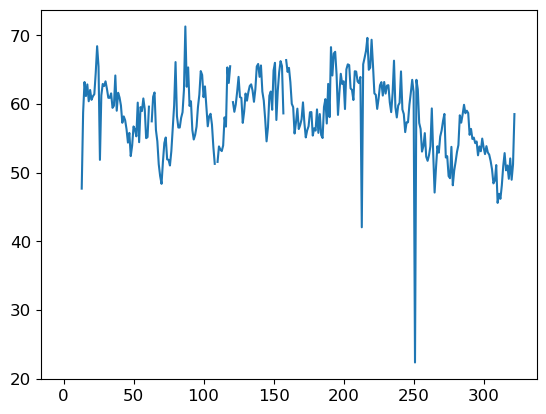

In [21]:
plt.plot(cwv)

/var/folders/9x/209ltwrn2b359nrrh4638hv40000gp/T/ipykernel_15278/9671825.py:8: RuntimeWarning: Mean of empty slice
  var_mean = np.nanmean(cfad_invar[it_dry], axis=0)
/var/folders/9x/209ltwrn2b359nrrh4638hv40000gp/T/ipykernel_15278/9671825.py:10: RuntimeWarning: Mean of empty slice
  mean_rh = np.nanmean(rh_asc[it_dry], axis=0)
/var/folders/9x/209ltwrn2b359nrrh4638hv40000gp/T/ipykernel_15278/9671825.py:31: RuntimeWarning: Mean of empty slice
  var_mean = np.nanmean(cfad_invar[it_mid], axis=0)
/var/folders/9x/209ltwrn2b359nrrh4638hv40000gp/T/ipykernel_15278/9671825.py:33: RuntimeWarning: Mean of empty slice
  mean_rh = np.nanmean(rh_asc[it_mid], axis=0)
/var/folders/9x/209ltwrn2b359nrrh4638hv40000gp/T/ipykernel_15278/9671825.py:51: RuntimeWarning: Mean of empty slice
  var_mean = np.nanmean(cfad_invar[it_moist], axis=0)
/var/folders/9x/209ltwrn2b359nrrh4638hv40000gp/T/ipykernel_15278/9671825.py:53: RuntimeWarning: Mean of empty slice
  mean_rh = np.nanmean(rh_asc[it_moist], axis=0)
/var

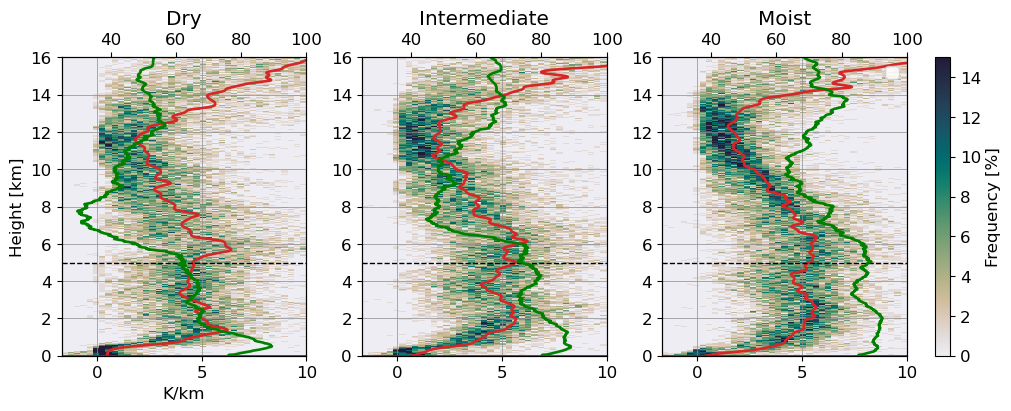

In [23]:
# Dependence on moisture

fig_x = 10
fig_y = 4.
fig, axs = plt.subplots(1,3, figsize=(fig_x,fig_y), layout="constrained",) # row, column

var_cfad = compute_cfad(cfad_invar[it_dry], bins)
var_mean = np.nanmean(cfad_invar[it_dry], axis=0)

mean_rh = np.nanmean(rh_asc[it_dry], axis=0)

figdata = {
    'pltvar': var_cfad,
    'meanvar': var_mean,
    'bins': bins,
    'zeroc': np.nanmean(snd_asc['hght_0c']),
    'mean_rh':  mean_rh,
    'fig_title': 'Dry',#r'$d\theta/dz$',
    'xtitle': 'K/km',
    'extend': 'both',
           }

plot_cfad_multi(figdata, fig, axs[0])

axs[0].set_ylabel('Height [km]')
axs[0].set_xlabel(figdata['xtitle'])

################################################

var_cfad = compute_cfad(cfad_invar[it_mid], bins)
var_mean = np.nanmean(cfad_invar[it_mid], axis=0)

mean_rh = np.nanmean(rh_asc[it_mid], axis=0)

figdata = {
    'pltvar': var_cfad,
    'meanvar': var_mean,
    'bins': bins,
    'zeroc': np.nanmean(snd_asc['hght_0c']),
    'mean_rh':  mean_rh,
    'fig_title': 'Intermediate',#r'$d\theta/dz$',
    'xtitle': 'K/km',
    'extend': 'both',
           }

plot_cfad_multi(figdata, fig, axs[1])

################################################

var_cfad = compute_cfad(cfad_invar[it_moist], bins)
var_mean = np.nanmean(cfad_invar[it_moist], axis=0)

mean_rh = np.nanmean(rh_asc[it_moist], axis=0)

figdata = {
    'pltvar': var_cfad,
    'meanvar': var_mean,
    'bins': bins,
    'zeroc': np.nanmean(snd_asc['hght_0c']),
    'mean_rh':  mean_rh,
    'fig_title': 'Moist',#r'$d\theta/dz$',
    'xtitle': 'K/km',
    'extend': 'both',
           }

plot_cfad_multi(figdata, fig, axs[2], do_colorbar=True)

plt.legend()

plt.show()
plt.close()

/var/folders/9x/209ltwrn2b359nrrh4638hv40000gp/T/ipykernel_15278/1809422077.py:27: RuntimeWarning: Mean of empty slice
  var_mean_int = np.nanmean(cfad_invar[it_mid], axis=0)
/var/folders/9x/209ltwrn2b359nrrh4638hv40000gp/T/ipykernel_15278/1809422077.py:28: RuntimeWarning: Mean of empty slice
  mean_rh_int = np.nanmean(rh_asc[it_mid], axis=0)
/var/folders/9x/209ltwrn2b359nrrh4638hv40000gp/T/ipykernel_15278/1809422077.py:31: RuntimeWarning: Mean of empty slice
  var_mean = np.nanmean(cfad_invar[it_dry], axis=0) - var_mean_int
/var/folders/9x/209ltwrn2b359nrrh4638hv40000gp/T/ipykernel_15278/1809422077.py:32: RuntimeWarning: Mean of empty slice
  mean_rh = np.nanmean(rh_asc[it_dry], axis=0) - mean_rh_int
/var/folders/9x/209ltwrn2b359nrrh4638hv40000gp/T/ipykernel_15278/1809422077.py:55: RuntimeWarning: Mean of empty slice
  var_mean = np.nanmean(cfad_invar[it_mid], axis=0)
/var/folders/9x/209ltwrn2b359nrrh4638hv40000gp/T/ipykernel_15278/1809422077.py:57: RuntimeWarning: Mean of empty slice

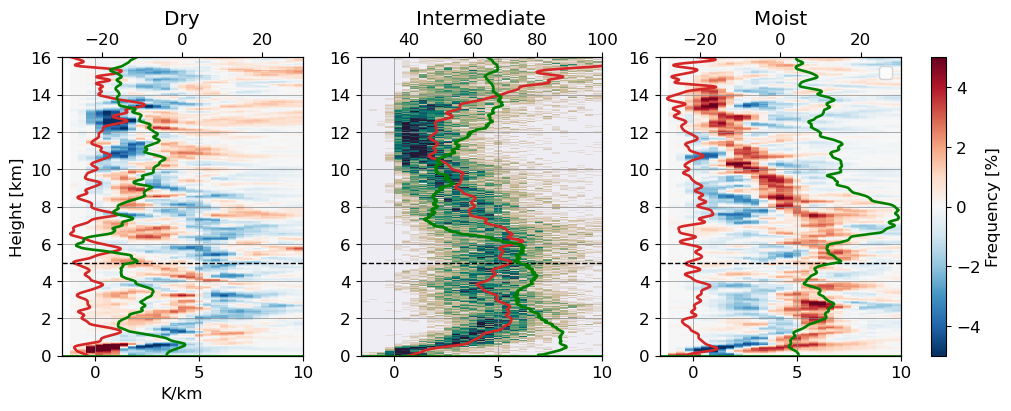

In [24]:
def cfad_smooth(invar, nx_smooth=3, nz_smooth=15):
    invar_pd = pd.DataFrame(invar)
    var_sm1 = invar_pd.rolling(window=nx_smooth, center=True, closed='both', min_periods=3).mean()
    var_trns = var_sm1.transpose()
    var_sm = var_trns.rolling(window=nz_smooth, center=True, closed='both', min_periods=3).mean()
    # var_sm = var_sm2.transpose()
    return np.squeeze(np.array(var_sm.transpose()))
def prof_smooth(invar, nx_smooth=15):
    invar_pd = pd.DataFrame(invar)
    var_sm1 = invar_pd.rolling(window=nx_smooth, center=True, closed='both', min_periods=3).mean()
    return np.squeeze(np.array(var_sm1))

# Dependence on moisture

# Bin settings
nbin=30
fmin=-2
fmax=10#15
step=(fmax-fmin)/nbin
bins=np.arange(fmin,fmax,step)+step

fig_x = 10
fig_y = 4.
fig, axs = plt.subplots(1,3, figsize=(fig_x,fig_y), layout="constrained",) # row, column

var_cfad_int = compute_cfad(cfad_invar[it_mid], bins)
var_mean_int = np.nanmean(cfad_invar[it_mid], axis=0)
mean_rh_int = np.nanmean(rh_asc[it_mid], axis=0)

var_cfad = compute_cfad(cfad_invar[it_dry], bins) - var_cfad_int
var_mean = np.nanmean(cfad_invar[it_dry], axis=0) - var_mean_int
mean_rh = np.nanmean(rh_asc[it_dry], axis=0) - mean_rh_int

figdata = {
    'pltvar': cfad_smooth(var_cfad),
    # 'meanvar': var_mean,
    'meanvar': prof_smooth(var_mean),
    'bins': bins,
    'zeroc': np.nanmean(snd_asc['hght_0c']),
    # 'mean_rh':  mean_rh,
    'mean_rh':  prof_smooth(mean_rh),
    'fig_title': 'Dry',#r'$d\theta/dz$',
    'xtitle': 'K/km',
    'extend': 'both',
           }

plot_cfad_multi(figdata, fig, axs[0], ianom=True)

axs[0].set_ylabel('Height [km]')
axs[0].set_xlabel(figdata['xtitle'])

################################################

var_cfad = compute_cfad(cfad_invar[it_mid], bins)
var_mean = np.nanmean(cfad_invar[it_mid], axis=0)

mean_rh = np.nanmean(rh_asc[it_mid], axis=0)

figdata = {
    'pltvar': var_cfad,
    'meanvar': var_mean,
    'bins': bins,
    'zeroc': np.nanmean(snd_asc['hght_0c']),
    'mean_rh':  mean_rh,
    'fig_title': 'Intermediate',#r'$d\theta/dz$',
    'xtitle': 'K/km',
    'extend': 'both',
           }

plot_cfad_multi(figdata, fig, axs[1])

################################################

var_cfad = compute_cfad(cfad_invar[it_moist], bins) - var_cfad_int
var_mean = np.nanmean(cfad_invar[it_moist], axis=0) - var_mean_int
mean_rh = np.nanmean(rh_asc[it_moist], axis=0) - mean_rh_int

figdata = {
    'pltvar': cfad_smooth(var_cfad),
    # 'meanvar': var_mean,
    'meanvar': prof_smooth(var_mean),
    'bins': bins,
    'zeroc': np.nanmean(snd_asc['hght_0c']),
    # 'mean_rh':  mean_rh,
    'mean_rh':  prof_smooth(mean_rh),
    'fig_title': 'Moist',#r'$d\theta/dz$',
    'xtitle': 'K/km',
    'extend': 'both',
           }

plot_cfad_multi(figdata, fig, axs[2], do_colorbar=True, ianom=True)

plt.legend()

plt.show()
plt.close()

##### Binned by Midlevel RH

In [34]:
# Percentile approach for partitioning data into dry/wet periods via CWV

hght0 = 4.5 # km
hght1 = 6.5 # km
rh_midlev = np.nanmean(rh_asc[:,np.where((hght*1e-3 > hght0) & (hght*1e-3 < hght1))[0]], axis=1)

percentiles = [33,66]

rh_perc = np.nanpercentile(rh_midlev, percentiles)

it_dry = np.where(rh_midlev < rh_perc[0])[0]
it_moist = np.where(rh_midlev > rh_perc[1])[0]
it_mid = np.where((rh_midlev > rh_perc[0]) & (rh_midlev < rh_perc[1]))[0]
print('Percent of full record:')
print(np.round(it_dry.size/rh_midlev.size*1e2))
print(np.round(it_moist.size/rh_midlev.size*1e2))
print(np.round(it_mid.size/rh_midlev.size*1e2))

Percent of full record:
31.0
33.0
31.0


/var/folders/9x/209ltwrn2b359nrrh4638hv40000gp/T/ipykernel_15278/3425794239.py:5: RuntimeWarning: Mean of empty slice
  rh_midlev = np.nanmean(rh_asc[:,np.where((hght*1e-3 > hght0) & (hght*1e-3 < hght1))[0]], axis=1)


/var/folders/9x/209ltwrn2b359nrrh4638hv40000gp/T/ipykernel_15278/9671825.py:8: RuntimeWarning: Mean of empty slice
  var_mean = np.nanmean(cfad_invar[it_dry], axis=0)
/var/folders/9x/209ltwrn2b359nrrh4638hv40000gp/T/ipykernel_15278/9671825.py:10: RuntimeWarning: Mean of empty slice
  mean_rh = np.nanmean(rh_asc[it_dry], axis=0)
/var/folders/9x/209ltwrn2b359nrrh4638hv40000gp/T/ipykernel_15278/9671825.py:31: RuntimeWarning: Mean of empty slice
  var_mean = np.nanmean(cfad_invar[it_mid], axis=0)
/var/folders/9x/209ltwrn2b359nrrh4638hv40000gp/T/ipykernel_15278/9671825.py:33: RuntimeWarning: Mean of empty slice
  mean_rh = np.nanmean(rh_asc[it_mid], axis=0)
/var/folders/9x/209ltwrn2b359nrrh4638hv40000gp/T/ipykernel_15278/9671825.py:51: RuntimeWarning: Mean of empty slice
  var_mean = np.nanmean(cfad_invar[it_moist], axis=0)
/var/folders/9x/209ltwrn2b359nrrh4638hv40000gp/T/ipykernel_15278/9671825.py:53: RuntimeWarning: Mean of empty slice
  mean_rh = np.nanmean(rh_asc[it_moist], axis=0)
/var

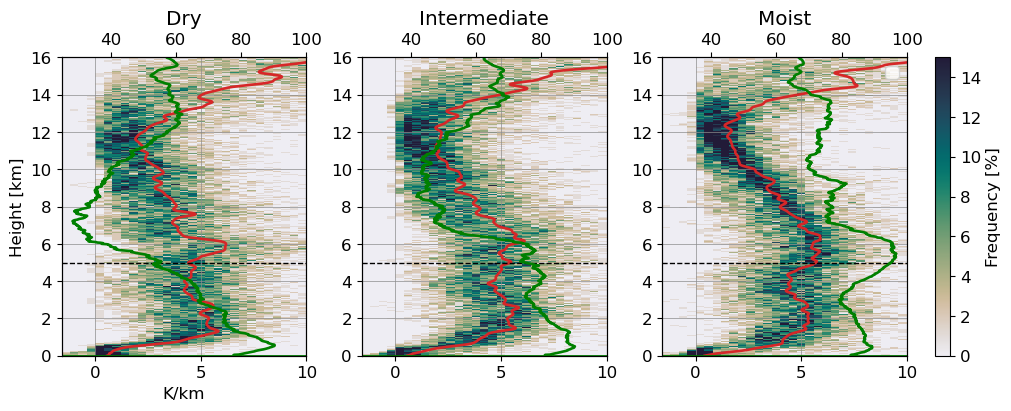

In [35]:
# Dependence on moisture

fig_x = 10
fig_y = 4.
fig, axs = plt.subplots(1,3, figsize=(fig_x,fig_y), layout="constrained",) # row, column

var_cfad = compute_cfad(cfad_invar[it_dry], bins)
var_mean = np.nanmean(cfad_invar[it_dry], axis=0)

mean_rh = np.nanmean(rh_asc[it_dry], axis=0)

figdata = {
    'pltvar': var_cfad,
    'meanvar': var_mean,
    'bins': bins,
    'zeroc': np.nanmean(snd_asc['hght_0c']),
    'mean_rh':  mean_rh,
    'fig_title': 'Dry',#r'$d\theta/dz$',
    'xtitle': 'K/km',
    'extend': 'both',
           }

plot_cfad_multi(figdata, fig, axs[0])

axs[0].set_ylabel('Height [km]')
axs[0].set_xlabel(figdata['xtitle'])

################################################

var_cfad = compute_cfad(cfad_invar[it_mid], bins)
var_mean = np.nanmean(cfad_invar[it_mid], axis=0)

mean_rh = np.nanmean(rh_asc[it_mid], axis=0)

figdata = {
    'pltvar': var_cfad,
    'meanvar': var_mean,
    'bins': bins,
    'zeroc': np.nanmean(snd_asc['hght_0c']),
    'mean_rh':  mean_rh,
    'fig_title': 'Intermediate',#r'$d\theta/dz$',
    'xtitle': 'K/km',
    'extend': 'both',
           }

plot_cfad_multi(figdata, fig, axs[1])

################################################

var_cfad = compute_cfad(cfad_invar[it_moist], bins)
var_mean = np.nanmean(cfad_invar[it_moist], axis=0)

mean_rh = np.nanmean(rh_asc[it_moist], axis=0)

figdata = {
    'pltvar': var_cfad,
    'meanvar': var_mean,
    'bins': bins,
    'zeroc': np.nanmean(snd_asc['hght_0c']),
    'mean_rh':  mean_rh,
    'fig_title': 'Moist',#r'$d\theta/dz$',
    'xtitle': 'K/km',
    'extend': 'both',
           }

plot_cfad_multi(figdata, fig, axs[2], do_colorbar=True)

plt.legend()

plt.show()
plt.close()